# Estimating Correlations between Clinical Trials Outcomes (Single Phase)

Sergey Zhuk, 24.08.2020


The document contains the code used in the estimation for the following paper:

* Rey, Alexey, Olga Rozanova, and Sergey Zhuk. “Estimating Correlations between Clinical Trial Outcomes,” 2020.

This document considers a simplified case in which the all phases clinical trials of a drug/vaccine are combined into a single phase. The code for the "three phases" you can find in *ctcorrelations-three-phases.ipynb*.

## 1. Model Overview

*(You can find a more detailed description in the paper).*

* There are K diseases ($k=1,\dots,K$) and $n^{k}$ vaccine candidates for disease $k$.

* The outcome of the clinicals trial for a given candidate can be aggregated into a continuous "quality" measure $Y_{i}^{k}$.

* If $Y_{i}^{k}>\mu$, then the clinical trial is successful, and the vaccine candidate $i$ is approved.

* $Y_{i}^{k}\sim \mathcal{N}(0, 1)$ and the vector $\{Y_{i}^{k}\}$ for $k=1,\dots,K,\ i=1,\dots,n_{k}$ has the multivariate normal distribution (with possibly correlated outcomes for different vaccine candidates).

* To represent the correlation matrix, we use factor models. For example, if correlation between vaccine candidates within the same disease is $\rho$ this can be expressed as:
$$Y_{i}^{k}=\sqrt{\rho}\cdot F^{k}+\sqrt{1-\rho}\cdot\varepsilon_{i}^{k}$$
$$\varepsilon_{i}^{k},F^{k}\sim\mathcal{N}(0,1)\ iid$$

* The "quality" $Y_{i}^{k}$ is a latent variable, which is not directly observable. We observe only the number of successful candidates for each disease $S^k$ defined as:

$$
X_{i}^{k}=\left\{\begin{array}{ll}
1 & if\ Y_{i}^{k}\ge\mu\\
0 & if\ Y_{i}^{k}<\mu
\end{array}\right.
\qquad S^{k}=\sum_{i=1}^{n_{k}}X_{i}^{k}$$

* The correlations between $Y_{i}^{k}$ affect the distribution of $S^k$, which allows us to estimate these correlations.

## 2. Data

To illustrate our methodology we estimate correlations based on the data from:
* Lo, Andrew W, Kien Wei Siah, and Chi Heem Wong. “Estimating Probabilities of Success of Vaccine and Other Anti-Infective Therapeutic Development Programs.” Working Paper. NBER, May 2020. https://doi.org/10.3386/w27176.

We use table 3 (for industry-sponsored vaccine development), which is reproduced below.
* *P1 Paths, P2 Paths, P3 Paths:* the number of projects with the known outcome of a given phase.
* *PoS12, PoS23, Pos3A:* the share of projects successfully transitioned to the next phase (A - means "regulatory acceptance").
* *Paths:* the number of projects with the known overall outcome.
* *PoS1A:* the share of overall succesfull projects (that reached regulatory acceptance).

For the simplified single phase estimation we rely only the overall outcomes from *Paths* and *PoS1A*. The code below constructs "*outcomes*" matrix out of these two columns (only we replace the share of successful project with the number of them). 

In [1]:
import numpy as np
import pandas as pd

data = pd.DataFrame(
    [['Bacterial Skin Infection',12,83.3,10.8,7,14.3,13.2,0.0,0.0,1,0.0,0.0,9,0.0,0.0],
    ['Chikungunya',6,83.3,15.2,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0,0.0],
    ['Clostridium difficile',6,100.0,0.0,6,33.3,19.2,0.0,0.0,0,0.0,0.0,4,0.0,0.0],
    ['Cytomegalovirus Infection (CMV)',14,57.1,13.2,3,33.3,27.2,0.0,0.0,0,0.0,0.0,8,0.0,0.0],
    ['Ebola',13,53.8,13.8,7,57.1,18.7,28.6,20.2,2,100.0,0.0,11,18.2,11.6],
    ['Hepatitis B Virus (HBV)',213,94.8,1.5,187,74.9,3.2,54.5,3.7,132,77.3,3.6,190,53.7,3.6],
    ['Hepatitis C Virus (HCV)',27,70.4,8.8,15,0.0,0.0,0.0,0.0,0,0.0,0.0,23,0.0,0.0],
    ['Human Immunodeficiency Virus (HIV)',181,65.2,3.5,95,36.8,4.9,0.0,0.0,21,0.0,0.0,144,0.0,0.0],
    ['Human Papillomavirus (HPV)',120,88.3,2.9,69,52.2,6.0,36.2,6.1,30,83.3,6.8,77,32.5,5.3],
    ['Intra-abdominal Infections',1,100.0,0.0,1,100.0,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0],
    ['Japanese Encephalitis',35,100.0,0.0,35,71.4,7.6,65.7,8.1,24,95.8,4.1,34,67.6,8.0],
    ['Marburg',3,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,3,0.0,0.0],
    ['Middle East Respiratory Syndrome (MERS)',4,50.0,25.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,2,0.0,0.0],
    ['Monkeypox',1,100.0,0.0,1,100.0,0.0,100.0,0.0,1,100.0,0.0,1,100.0,0.0],
    ['Norovirus',6,100.0,0.0,5,0.0,0.0,0.0,0.0,0,0.0,0.0,5,0.0,0.0],
    ['Otitis Media',23,95.7,4.3,22,81.8,8.2,45.5,10.6,18,55.6,11.7,23,43.5,10.3],
    ['Rabies',47,91.5,4.1,40,87.5,5.2,65.0,8.1,30,86.7,6.2,39,66.7,7.5],
    ['Respiratory Infections',640,79.1,1.6,465,66.9,2.2,50.1,2.4,287,81.2,2.3,575,40.5,2.0],
    ['Rotavirus',72,97.2,1.9,70,91.4,3.3,68.6,6.0,53,90.6,4.0,61,78.7,5.2],
    ['Sepsis',13,38.5,13.5,5,80.0,17.9,0.0,0.0,4,0.0,0.0,13,0.0,0.0],
    ['Severe Acute Respiratory Syndrome (SARS)',1,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0,0.0],
    ['Smallpox',11,81.8,11.6,8,62.5,17.1,50.0,17.7,5,80.0,17.9,10,40.0,15.5],
    ['Urinary Tract Infections',3,100.0,0.0,3,100.0,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0],
    ['West Nile Virus (WNV)',4,25.0,21.7,1,100.0,0.0,0.0,0.0,1,0.0,0.0,4,0.0,0.0],
    ['Yellow Fever',30,90.0,5.5,26,73.1,8.7,57.7,10.5,15,100.0,0.0,25,60.0,9.8],
    ['Zika',2,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,2,0.0,0.0],
    ['Others',350,87.1,1.8,268,63.4,2.9,47.0,3.2,142,88.7,2.7,285,44.2,2.9],
    ['Total',1838,82.5,0.9,1339,65.4,1.3,45.9,1.4,768,80.1,1.4,1552,39.6,1.2]],
    columns = ['Disease','P1 Paths','PoS12','SE12','P2 Paths','PoS23','SE23','PoS2A','SE2A','P3 Paths','PoS3A','SE3A','Paths','PoS1A','SE1A']
)
display(data)
data = data[np.logical_and(data['Disease'] != 'Total', data['Disease'] != 'Others')] # remove 'Others' and 'Total'
data['S1A'] = np.round(data['Paths']*data['PoS1A']/100).astype(int)
outcomes = np.array(data[['Paths', 'S1A']]) # construct outcomes matrix
data[['Disease','Paths', 'S1A']]

,Disease,P1 Paths,PoS12,SE12,P2 Paths,PoS23,SE23,PoS2A,SE2A,P3 Paths,PoS3A,SE3A,Paths,PoS1A,SE1A
0,Bacterial Skin Infection,12,83.3,10.8,7,14.3,13.2,0.0,0.0,1,0.0,0.0,9,0.0,0.0
1,Chikungunya,6,83.3,15.2,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0,0.0
2,Clostridium difficile,6,100.0,0.0,6,33.3,19.2,0.0,0.0,0,0.0,0.0,4,0.0,0.0
3,Cytomegalovirus Infection (CMV),14,57.1,13.2,3,33.3,27.2,0.0,0.0,0,0.0,0.0,8,0.0,0.0
4,Ebola,13,53.8,13.8,7,57.1,18.7,28.6,20.2,2,100.0,0.0,11,18.2,11.6
5,Hepatitis B Virus (HBV),213,94.8,1.5,187,74.9,3.2,54.5,3.7,132,77.3,3.6,190,53.7,3.6
6,Hepatitis C Virus (HCV),27,70.4,8.8,15,0.0,0.0,0.0,0.0,0,0.0,0.0,23,0.0,0.0
7,Human Immunodeficiency Virus (HIV),181,65.2,3.5,95,36.8,4.9,0.0,0.0,21,0.0,0.0,144,0.0,0.0
8,Human Papillomavirus (HPV),120,88.3,2.9,69,52.2,6.0,36.2,6.1,30,83.3,6.8,77,32.5,5.3
9,Intra-abdominal Infections,1,100.0,0.0,1,100.0,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0


,Disease,Paths,S1A
0,Bacterial Skin Infection,9,0
1,Chikungunya,1,0
2,Clostridium difficile,4,0
3,Cytomegalovirus Infection (CMV),8,0
4,Ebola,11,2
5,Hepatitis B Virus (HBV),190,102
6,Hepatitis C Virus (HCV),23,0
7,Human Immunodeficiency Virus (HIV),144,0
8,Human Papillomavirus (HPV),77,25
9,Intra-abdominal Infections,1,0


## 3. Axiliary Code

In [2]:
import time
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import comb
from scipy.stats import chi2
from IPython.display import clear_output

def bnd(x, a, b): 
    # using sigmoid function transforms interval (-\infty,\infty) into interval (a, b)
    # is used below to restrict minimization to the interval (a, b)
    t = np.exp(-np.abs(x))
    return a+(b-a)*((x>0)*1+(x<=0)*t)/(1+t)

def stderrors(lf, p, dp): # is used to calculated standard errors
    k = list(dp.keys()); m = len(k)
    I = np.zeros((m, m)); dv = np.zeros(m)
    p0 = dict()
    for i in range(m):
        p0[k[i]] = p[k[i]]

    for d in range(len(outcomes)):
        for i in range(m):
            pa = p0.copy(); pb = p0.copy()
            pa[k[i]] = pa[k[i]] - dp[k[i]]
            pb[k[i]] = pb[k[i]] + dp[k[i]]
            la = lf(**pa, outcomes = outcomes[d:d+1])
            lb = lf(**pb, outcomes = outcomes[d:d+1])
            dv[i] = (lb-la)/2/dp[k[i]]
        for i in range(m):
            for j in range(m):
                I[i,j] = I[i,j] + dv[i]*dv[j]
    invI = np.linalg.inv(I)
    se = dict()
    for i in range(m):
        se[k[i]] = np.sqrt(invI[i, i])
    return se

## 4. Estimation

### 4.1 Model (a). No correlation

Model:

$$Y_{i}^{k}=\varepsilon_{i}^{k}\ge\mu\qquad\varepsilon_{i}^{k}\sim\mathcal{N}(0,1)\ \ iid$$

We estimate $\mu$ with maximum likelihood.

In [3]:
def likelihood_a(mu, outcomes = outcomes):
    nd = len(outcomes)
    ns = outcomes[:,1]; nfail = outcomes[:,0] - outcomes[:,1]
    factor = comb(outcomes[:,0], outcomes[:,1])
    lk = 0
    p = norm.cdf(-mu)
    for i in range(0, nd):
        x = factor[i]*(p**ns[i])*((1-p)**nfail[i])
        if x == 0: return -np.inf
        lk += np.log(x)
    return lk

resa = optimize.minimize(lambda t: -likelihood_a(t), x0 = 0)
resa.l = -resa.fun
resa.p = {'mu': resa.x[0]}
resa.se = stderrors(likelihood_a, resa.p, dp = {'mu': 0.01})

print('Model (a), no correlation:')
for k in resa.p.keys():
    print('    {} = {:.4f} ({:.4f})'.format(k, resa.p[k], resa.se[k]))
print('    log(likelihood) =', np.round(resa.l, 4))

Model (a), no correlation:
    mu = 0.2899 (0.0087)
    log(likelihood) = -175.5435


### 4.2 Model (b). Correlation $\rho$ for vaccine candidates within the same disease

Model:
$$Y_{i}^{k}=\rho\cdot F^{k}+\sqrt{1-\rho}\cdot\varepsilon_{i}^{k}\ge\mu$$

$$F^k, \varepsilon_{i}^{k}\sim N(0,1)\ \ iid$$
We estimate both $\mu$ and $\rho$ with maximum likelihood.

In [4]:
def likelihood_b(mu, rho, outcomes = outcomes):
    nd = len(outcomes) # number of diseases
    sigma = np.sqrt(1-rho); beta = np.sqrt(rho)
    nsuccess = outcomes[:,1]; nfail = outcomes[:,0] - outcomes[:,1]
    factor = comb(outcomes[:,0], outcomes[:,1])
    lk = 0
    for i in range(0, nd):
        def g(F):
            p = norm.cdf((-mu + F*beta)/sigma)
            return factor[i]*(p**nsuccess[i])*((1-p)**nfail[i])*norm.pdf(F)
        x = integrate.quad(g, -np.inf, np.inf)[0]
        if x == 0: return -np.inf
        lk += np.log(x)
    return lk

def parameters_b(t):
    return {'mu': t[0], 'rho': bnd(t[1], 0, 0.95)}

resb = optimize.minimize(lambda t: -likelihood_b(**parameters_b(t)), x0 = np.zeros(2))

resb.l = -resb.fun # likelihood
resb.p = parameters_b(resb.x) # parameters
resb.se = stderrors(likelihood_b, resb.p, dp = {'mu': 0.01, 'rho': 0.01}) #standard errors

print('Model (b), with correlation:')
for k in resb.p.keys():
    print('    {} = {:.4f} ({:.4f})'.format(k, resb.p[k], resb.se[k]))
print('\n    log(likelihood) =', np.round(resb.l, 4))
# LR test
LR = 2*(resb.l - resa.l); pvalue = 1 - chi2.cdf(LR,1)
print('    LR (model a) = {:.4f} (p-value = {:.4f})'.format(LR, pvalue))

Model (b), with correlation:
    mu = 0.7272 (0.2891)
    rho = 0.6744 (0.1848)

    log(likelihood) = -56.3397
    LR (model a) = 238.4076 (p-value = 0.0000)


## 5. Applications

### 5.1 Probability of Overall Success

Model (b): First, we calculate of success for a given difficulty factor $F$.

In [5]:
def vac_prob_F(mu, rho, F, n):
    sigma = np.sqrt(1-rho); beta = np.sqrt(rho)
    p = norm.cdf((- mu + beta*F)/sigma)
    return 1-(1-p)**n

quantile = np.array([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
F = norm.ppf(quantile)
prob1 = F.copy(); prob2 = F.copy()
for i in range(0, len(F)):
    prob1[i] = vac_prob_F(**resb.p, F = F[i], n = 10)
    prob2[i] = vac_prob_F(**resb.p, F = F[i], n = 20)

dfq = pd.DataFrame({'$quantile$': quantile, '$F$': F, '$p_{success}$ $(n=10)$': 100*prob1, '$p_{success}$ $(n=20)$': 100*prob2})
dfq.style.format({'$quantile$': '{:.2f}', '$F$': '{:.2f}', '$p_{success}$ $(n=10)$': '{:.4g}%',
                 '$p_{success}$ $(n=20)$': '{:.4g}%'}).set_properties(**{'text-align': 'center'})

,$quantile$,$F$,$p_{success}$ $(n=10)$,$p_{success}$ $(n=20)$
0,0.01,-2.33,0.001899%,0.003799%
1,0.05,-1.64,0.1355%,0.2708%
2,0.10,-1.28,0.9049%,1.802%
3,0.25,-0.67,11.72%,22.06%
4,0.50,0.00,65.62%,88.18%
5,0.75,0.67,99.17%,99.99%
6,0.90,1.28,100%,100%
7,0.95,1.64,100%,100%
8,0.99,2.33,100%,100%


The same results as a graph:

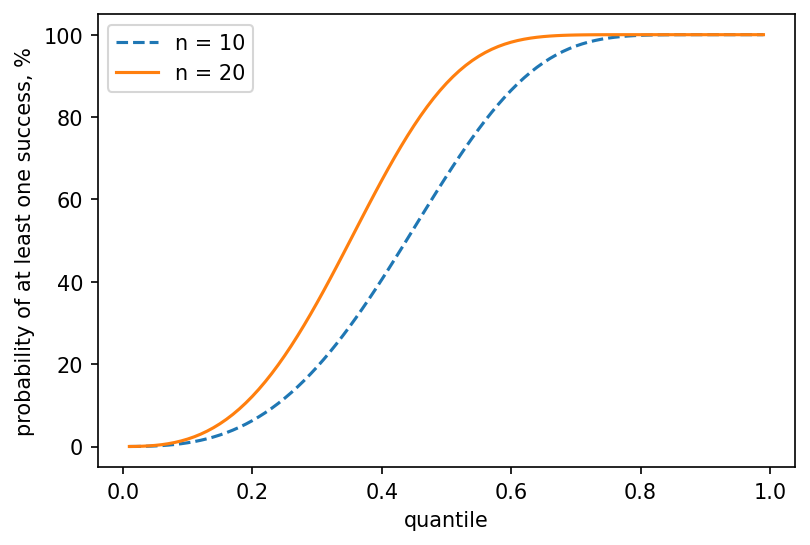

In [6]:
quantile = np.arange(0.01, 1, 0.01)
F = norm.ppf(quantile)
prob1 = F.copy(); prob2 = F.copy()
for i in range(0, len(F)):
    prob1[i] = vac_prob_F(**resb.p, F = F[i], n = 10)
    prob2[i] = vac_prob_F(**resb.p, F = F[i], n = 20)

import matplotlib.pyplot as plt
plt.figure(dpi = 150)
plt.plot(quantile, 100*prob1, '--', quantile, 100*prob2, '-')
plt.xlabel('quantile')
plt.ylabel('probability of at least one success, %')
plt.legend(['n = 10', 'n = 20']);

Now, we can calculate the overall probability by average over $F~\sim\mathcal{N}(0,1)$ and compare the results with model (a).

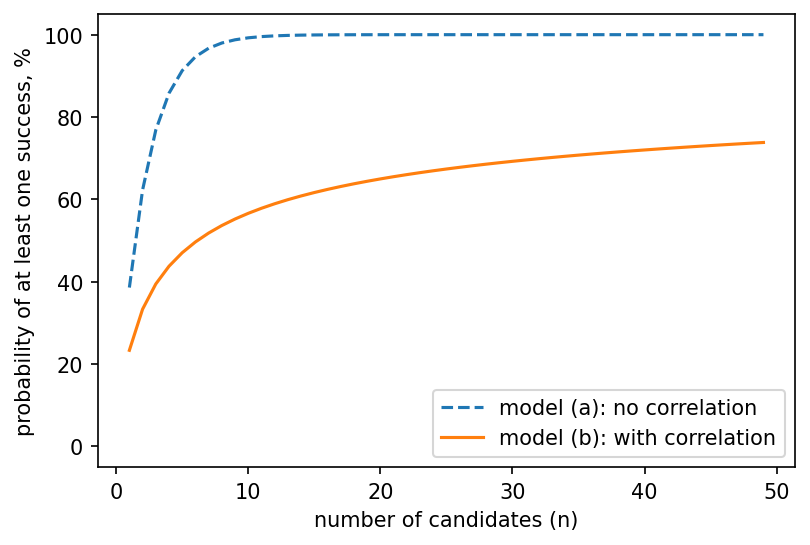

In [7]:
def vac_prob_a(mu, n):
    return 1 - norm.cdf(resa.p['mu'])**n

def vac_prob_b(mu, rho, n):
    return integrate.quad(lambda x: vac_prob_F(mu = mu, rho = rho, F = x, n = n)*norm.pdf(x), -np.inf, np.inf)[0]

n = np.arange(1, 50)
prob_a = np.zeros(len(n)); prob_b = np.zeros(len(n))

for i in range(0, len(n)):
    prob_a[i] = vac_prob_a(**resa.p, n = n[i])
    prob_b[i] = vac_prob_b(**resb.p, n = n[i])

plt.figure(dpi = 150)
plt.plot(n, 100*prob_a, '--', n, 100*prob_b, '-'); plt.ylim((-5, 105))
plt.xlabel('number of candidates (n)')
plt.ylabel('probability of at least one success, %')
plt.legend(['model (a): no correlation', 'model (b): with correlation'], loc = 'lower right');

### 5.2 Probability of Success for a Given Candidate

Suppose we have a new disease. Consider one specific vaccine/drug candidate. The code below calculates the probability that it will succeeed (that it will transition to success) for both estimated models. See the discussion in the paper about the origin of the difference.

In [8]:
# Model (a): no correlations
prob_a1 = vac_prob_a(**resa.p, n = 1)
prob_b1 = vac_prob_b(**resb.p, n = 1)

print('Model (a) single candidate success probability = {:.4f}%'.format(100*prob_a1))
# This, probability is exactly the same as the share of overall successful outcomes
n = sum(data['Paths']); s = sum(data['S1A'])
print('Share of overall successful outcomes = {}/{} = {}%'.format(s, n, 100*s/n))
print('\nModel (b) single candidate success probability = {:.4f}%'.format(100*prob_b1))

Model (a) single candidate success probability = 38.5951%
Share of overall successful outcomes = 489/1267 = 38.59510655090766%

Model (b) single candidate success probability = 23.3546%


### 5.3 Optimal Investment Strategy


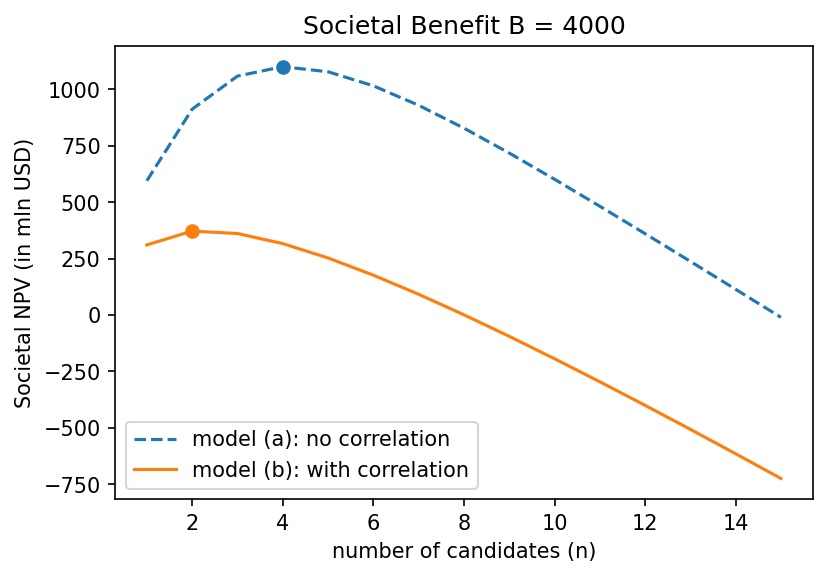

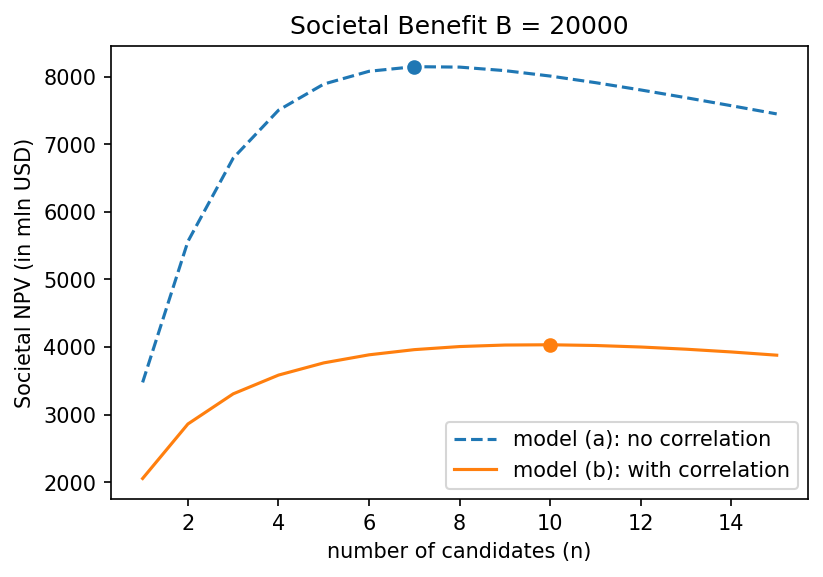

In [9]:
I = 125 # average cost of clinical trials per candidate (in mln USD)
B = [4000, 20000] # societal benefits from obtaining a successful drug/vaccine (in mln USD)
r = 0.1 # discount rate
T = 8 # number of years from the start till the end of clinical trials

n = np.arange(1, 16)
prob_a = np.zeros(len(n)); prob_b = np.zeros(len(n))
for i in range(0, len(n)):
    prob_a[i] = vac_prob_a(**resa.p, n = n[i])
    prob_b[i] = vac_prob_b(**resb.p, n = n[i])
    
for j in range(0, len(B)):
    NPV_a = B[j]*prob_a/((1+r)**T) - I*n
    NPV_b = B[j]*prob_b/((1+r)**T) - I*n
    plt.figure(dpi = 150)
    plt.plot(n, NPV_a, '--', n, NPV_b, '-'); #plt.ylim((-5, 105))
    plt.scatter(n[np.argmax(NPV_a)], NPV_a[np.argmax(NPV_a)])
    plt.scatter(n[np.argmax(NPV_b)], NPV_b[np.argmax(NPV_b)])
    plt.xlabel('number of candidates (n)')
    plt.ylabel('Societal NPV (in mln USD)')
    plt.legend(['model (a): no correlation', 'model (b): with correlation']);
    plt.title('Societal Benefit B = {}'.format(B[j]))